In [1]:
from session_7 import create_cifar10_dataloaders, MetricsCallback, Model3
import matplotlib.pyplot as plt
from torchvision import transforms
from torchsummary import summary

import lightning as L
from lightning.pytorch.callbacks import TQDMProgressBar

In [2]:
L.seed_everything(0, workers=True)
model = Model3()
summary(model, input_size=(3, 32, 32))

Seed set to 0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           4,128
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
      BatchNorm2d-14           [-1, 32,

In [3]:
train_loader, test_loader = create_cifar10_dataloaders(
    batch_size=128,
    data_path="../data",
    train_transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (0.49139968, 0.48215841, 0.44653091),
                (0.24703223, 0.24348513, 0.26158784),
            ),
        ]
    ),
    test_transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (0.49139968, 0.48215841, 0.44653091),
                (0.24703223, 0.24348513, 0.26158784),
            ),
        ]
    ),
)

In [4]:
metrics = MetricsCallback()
trainer = L.Trainer(
    max_epochs=20,
    logger=False,
    enable_checkpointing=False,
    callbacks=[TQDMProgressBar(leave=True), metrics],
)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | block1    | Sequential         | 9.4 K  | train
1 | block2    | Sequential         | 34.3 K | train
2 | block3    | Sequential         | 34.3 K | train
3 | block4    | Sequential         | 9.7 K  | train
4 | train_acc | MulticlassAccuracy | 0      | train
5 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
87.6 K    Trainable params
0         Non-trainable params
87.6 K    Total params
0.350     Total estimated model params size (MB)
61        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 19: 100%|██████████| 391/391 [00:03<00:00, 99.84it/s, val_loss=0.845, val_acc=0.714, train_loss=0.728, train_acc=0.760] 

`Trainer.fit` stopped: `max_epochs=20` reached.


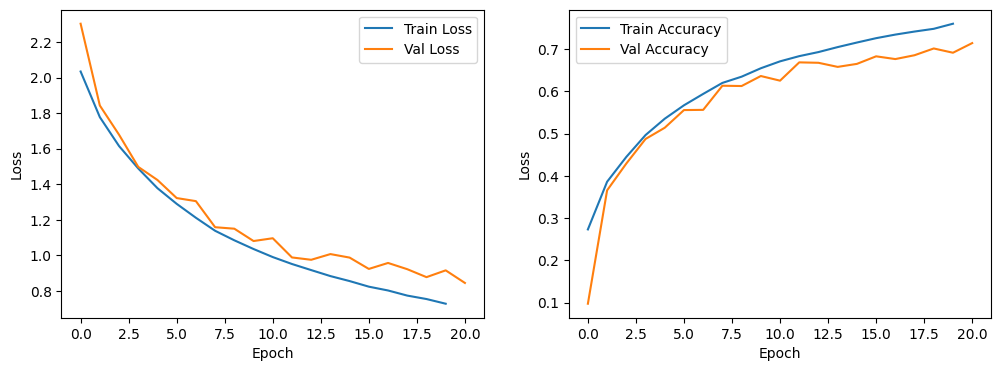

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
metrics.plot_loss(ax1)
metrics.plot_accuracy(ax2)
plt.show()

**Target**

Change the architecture to a pyramid style and look at the differences between this and the previous one ([`Model2`](../src/session_7/model_2.py))

**Result**

Changed the architecture as follows:

1. block 1 transitions from 3 -> 16 -> 32 channels.
2. block 2 and 3 transitions from 32 -> 48 -> 48 -> 32 channels. The last convolution is a 1x1 convolution, and the second last convolution is a strided convolution (reduce spatial dimensions)
3. block 4 transitions from 32 -> 10 -> GAP.

Parameter Count: 87,582

Train Acc: 76%

Test Acc: 71.4%

**Analysis**

The difference is less, but couple of things can be noticed:

1. Around 5% decrease in parameters
2. Increased receptive field compared to the previous model (52 vs 44)
3. More stable train and test accuracies and losses over 20 epochs
4. Achieves a better acc (both train and test) faster compared to the previous model.

This base model can be used instead of the previous one, and to this, depthwise separable convolutions, dilated convolutions can be added and augmentations can be used during training. 

